In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import RegressorMixin, TransformerMixin
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, StandardScaler
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, LinearRegression, ElasticNet, ElasticNetCV

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_validate, KFold
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import TimeSeriesSplit


In [2]:
# Import custom classes
from supervised_model_pipeline import EdaToolbox, RegressorMultiModelEvaluator

## Inspect the data

In [4]:
# Load the training data
tampa_file_path = '../../Data/Clean/combined/Tampa_combined.csv'
train_full_df = pd.read_csv(tampa_file_path)
train_full_df.head()

,DATE,MeanSalePrice,SalesCount,TotalTransactionValue,HomeValueIndex,HomeValueIndexSmSa,MarketTempIdx,DaysToClose,DaysOnZillow,ListingPriceCutAmt,...,PctSoldBelowList,MORTGAGE15US,MORTGAGE30US,RATE_DIFFERENCE,NUM_JOBS,GROWTH_PCT,People25PlusThousands_2019,PctHighSchoolDiploma_2019,PctBachelorsDegree_2019,CityName
0,2008-04-30,211207.0,2794.0,521732716.0,185862.203030,192542.173304,NaN,NaN,NaN,NaN,...,NaN,5.465,5.918,0.452,1199.2,-5.5,2293.35917,93.139933,33.616856,"TAMPA, FL"
1,2008-05-31,213179.0,2823.0,578339406.0,183472.687406,189275.385889,NaN,NaN,NaN,NaN,...,NaN,5.600,6.036,0.436,1195.7,-6.3,2293.35917,93.139933,33.616856,"TAMPA, FL"
2,2008-06-30,211632.0,2926.0,602587341.0,181305.569312,186093.368737,NaN,NaN,NaN,NaN,...,NaN,5.910,6.320,0.410,1192.0,-5.9,2293.35917,93.139933,33.616856,"TAMPA, FL"
3,2008-07-31,211499.0,2910.0,610305608.0,178918.643810,182949.526391,NaN,NaN,NaN,NaN,...,NaN,5.972,6.426,0.454,1185.3,-4.6,2293.35917,93.139933,33.616856,"TAMPA, FL"
4,2008-08-31,205078.0,2676.0,582528046.0,176202.714042,179726.913473,NaN,NaN,NaN,NaN,...,NaN,6.025,6.478,0.452,1182.3,-4.5,2293.35917,93.139933,33.616856,"TAMPA, FL"


In [5]:
# Remove columns that are too predictive
cols_to_remove = ['HomeValueIndexSmSa', 'HomeValueIndex']
train_full_df = train_full_df.drop(cols_to_remove, axis=1)

## Create an EdaToolbox object

In [6]:
# Initialize the EdaToolbox
target_col = 'MeanSalePrice'
eda = EdaToolbox(train_full_df, target_column=target_col)

In [7]:
col_info_df = eda.gather_initial_column_info()
col_info_df.head()

,data_type,max_value_count_pct,most_frequent_value,unique_values,missing_values,missing_values_pct,top_10_values
CityName,object,1.000000,"TAMPA, FL",1,0,0.0,"Index(['TAMPA, FL'], dtype='object', name='Cit..."
DATE,object,0.005128,2008-04-30,195,0,0.0,"Index(['2008-04-30', '2012-05-31', '2009-03-31..."
People25PlusThousands_2019,float64,1.000000,2293.35917,1,0,0.0,"Index([2293.35917], dtype='float64', name='Peo..."
PctHighSchoolDiploma_2019,float64,1.000000,93.139933,1,0,0.0,"Index([93.139933], dtype='float64', name='PctH..."
PctBachelorsDegree_2019,float64,1.000000,33.616856,1,0,0.0,"Index([33.616856], dtype='float64', name='PctB..."


In [8]:
eda.prune_infreq_categorical = 0.9
eda.prune_infreq_numerical = 0.95
eda.prune_pct_missing = 0.8

## First check the distribution of the target column and select an appropriate target column transformer

In [9]:
# It is not normally distributed. It has a long tail to the right. Need to try different target transformations
target_transformation_dict: dict[str, TransformerMixin] = {
    'StandardScaler': StandardScaler(),
    'PowerTransformer': PowerTransformer(standardize=False),
    'QuantileTransformer': QuantileTransformer(output_distribution='normal', n_quantiles=500, random_state=42),
}

In [10]:
# Create a dict of models for preliminary testing of target transformations
model_dict: dict[str, RegressorMixin] = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0, random_state=42),
    'Lasso Regression': Lasso(alpha=1.0, random_state=42),
    'ElasticNet Regression': ElasticNet(alpha=1.0, random_state=42),
    'LassoCV': LassoCV(),
    'ElasticNetCV': ElasticNetCV(),
    'RidgeCV': RidgeCV(np.logspace(-6, 6, 25)),
    'HistGradientBoost': HistGradientBoostingRegressor(max_iter=200, random_state=42)
}


In [11]:
kf_cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [12]:
# Use basic ordinal feature transformer
eda.feature_transformer = eda.get_basic_ordinal_feature_transformer()

In [13]:
# Evaluate RMSE for various regression models and target transformations with all ordinaly encoded categorical features
model_pred_cv_df = eda.analyze_target_column_transformation_predictions(target_transformation_dict, model_dict, kf_cv)
model_pred_cv_df

/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of 

,Linear Regression,Ridge Regression,Lasso Regression,ElasticNet Regression,LassoCV,ElasticNetCV,RidgeCV,HistGradientBoost
StandardScaler,0.162479,0.148507,0.999177,0.680230,0.221588,0.214791,0.150695,0.079051
PowerTransformer,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
QuantileTransformer,0.415552,0.377257,1.066912,0.731713,0.350500,0.350949,0.367978,0.343322


Note for Providence dataset
* HistGradientBoost best performance across varied transformations, especially StandardScaler
* Consistent poor performance of Lasso Regression 

In [14]:
# Evaluate RMSE for various regression models and target transformations with all ordinaly encoded categorical features without CV
model_pred_df = eda.analyze_target_column_transformation_predictions(target_transformation_dict, model_dict)
model_pred_df

/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of 

,Linear Regression,Ridge Regression,Lasso Regression,ElasticNet Regression,LassoCV,ElasticNetCV,RidgeCV,HistGradientBoost
StandardScaler,0.230671,0.148746,0.950858,0.636864,0.150369,0.149176,0.161669,0.086226
PowerTransformer,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
QuantileTransformer,0.415158,0.262523,0.833823,0.522625,0.173754,0.180214,0.244271,0.208069


Note for Providence dataset
* HistGradientBoost worse performance in StandardScaler, but not by much
* PowerTransformer consistently suspicious performance

In [15]:
# Use basic OHE feature transformer
eda.feature_transformer = eda.get_basic_ohe_feature_transformer()

In [16]:
# Evaluate RMSE for various regression models and target transformations with all ordinaly encoded categorical features
model_pred_cv_df = eda.analyze_target_column_transformation_predictions(target_transformation_dict, model_dict, kf_cv)
model_pred_cv_df

/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of 

,Linear Regression,Ridge Regression,Lasso Regression,ElasticNet Regression,LassoCV,ElasticNetCV,RidgeCV,HistGradientBoost
StandardScaler,0.178525,0.167779,0.999177,0.712437,0.189929,0.169118,0.170716,0.142879
PowerTransformer,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
QuantileTransformer,0.507798,0.474461,1.097364,0.803489,0.478406,0.466824,0.481099,0.354846


Note:
* HistGradientBoost best performance across all transformations, especially under StandardScaler and QuantileTransformer
* Ridge Regression emerges as the best-performing linear model with StandardScaler

In [17]:
# Evaluate RMSE for various regression models and target transformations with all ordinally encoded categorical features without CV
model_pred_df = eda.analyze_target_column_transformation_predictions(target_transformation_dict, model_dict)
model_pred_df

/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (500) is greater than the total number of 

,Linear Regression,Ridge Regression,Lasso Regression,ElasticNet Regression,LassoCV,ElasticNetCV,RidgeCV,HistGradientBoost
StandardScaler,0.229544,0.152847,0.950858,0.656357,0.161660,0.157864,0.164818,0.172566
PowerTransformer,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
QuantileTransformer,0.534572,0.360446,0.901220,0.581369,0.340776,0.333824,0.413507,0.266054


## Set the target and feature column tranformers

* Use the PowerTransformer for the target column
* Use the basic ordinal feature transformer

In [18]:
# Looks like the CV Models perform the best with a PowerTransformer.
# NOTE: These are pretty good RMSE scores with very basic encoding and no feature selection
eda.target_transformer = PowerTransformer(standardize=False)
eda.feature_transformer = eda.get_basic_ordinal_feature_transformer()

## Prepare the data for feature selection

In [19]:
# Gather initial column information sorted by data type and max value count to check for columns with high cardinality that can be pruned
col_info_df = eda.gather_initial_column_info()
col_info_df.head()

,data_type,max_value_count_pct,most_frequent_value,unique_values,missing_values,missing_values_pct,top_10_values
CityName,object,1.000000,"TAMPA, FL",1,0,0.0,"Index(['TAMPA, FL'], dtype='object', name='Cit..."
DATE,object,0.005128,2008-04-30,195,0,0.0,"Index(['2008-04-30', '2012-05-31', '2009-03-31..."
People25PlusThousands_2019,float64,1.000000,2293.35917,1,0,0.0,"Index([2293.35917], dtype='float64', name='Peo..."
PctHighSchoolDiploma_2019,float64,1.000000,93.139933,1,0,0.0,"Index([93.139933], dtype='float64', name='PctH..."
PctBachelorsDegree_2019,float64,1.000000,33.616856,1,0,0.0,"Index([33.616856], dtype='float64', name='PctB..."


In [20]:
# Set pruning thresholds on the eda object according to column data type and cardinality for this dataset
eda.prune_infreq_categorical = 0.9
eda.prune_infreq_numerical = 0.95
eda.prune_pct_missing = 0.8

## Feature analysis

In [21]:
# Frist check what the correlation and coefficient numbers look like
fa_df = eda.get_regression_feature_analysis_df()
fa_df.head()

Best RidgeCV alpha: 1.0 (R^2 score:  1.00)


/opt/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


,correlation_abs,coefficient_abs,pval,vif,PCA1_abs,PCA2_abs,total
ordinal_date__DATE,0.995056,3.255366e-07,0.797434,22.576080,0.097170,0.203751,1.295978
numerical__NUM_JOBS,0.947227,2.373008e-08,0.930580,20.438545,0.098677,0.240112,1.286017
numerical__TotalTransactionValue,0.904176,8.598202e-08,0.441258,28.611460,0.209733,0.109350,1.223260
numerical__NewConstructMeanSalePrice,0.276670,6.944946e-10,0.866057,6.967617,0.158331,0.368992,0.803994
numerical__ListingPriceCutAmt,0.248228,1.085697e-09,0.861121,17.403823,0.291197,0.259089,0.798514


/opt/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


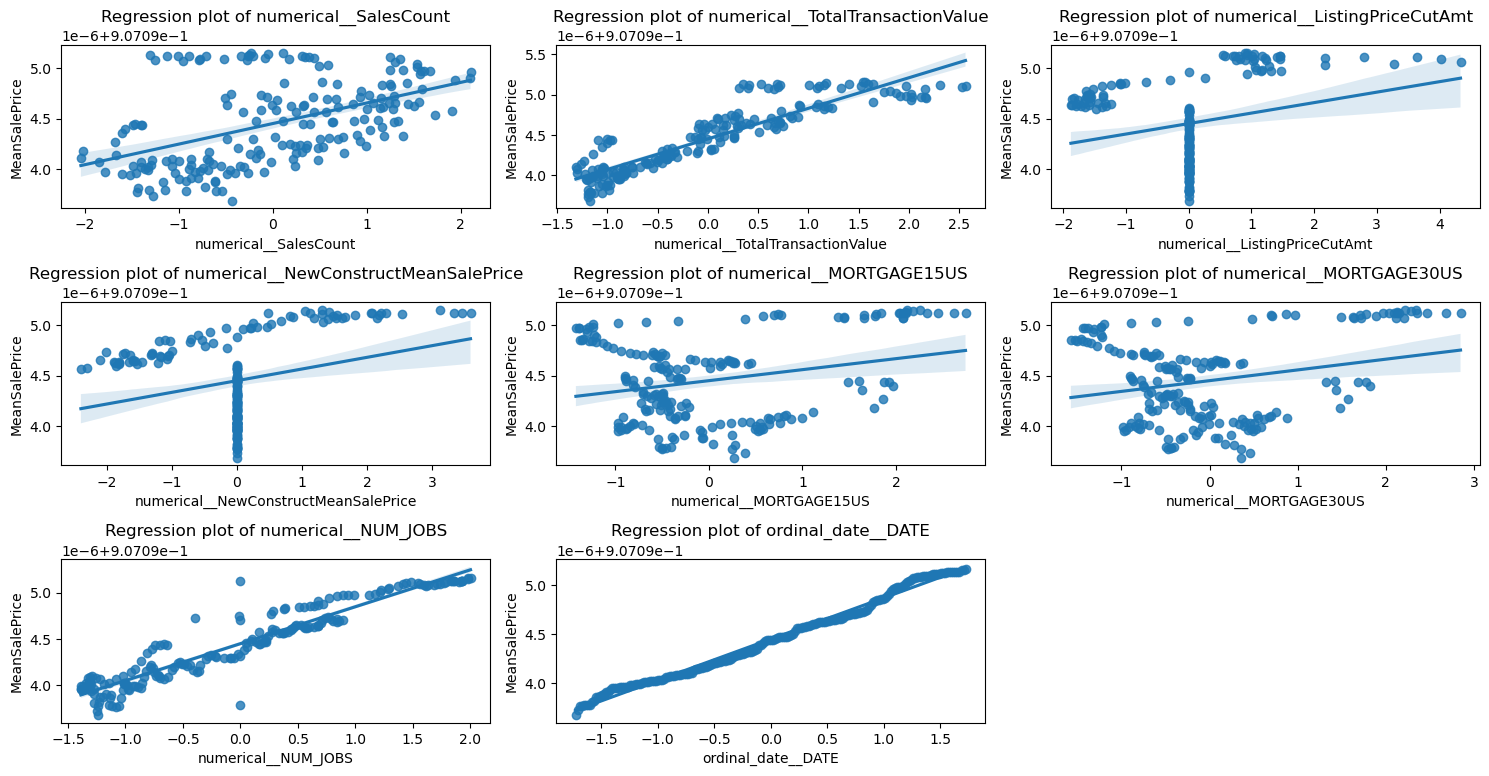

In [23]:
# Plot out the highly correlated features
eda.plot_regression_feature_correlations(corr_min=0.2)

/opt/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


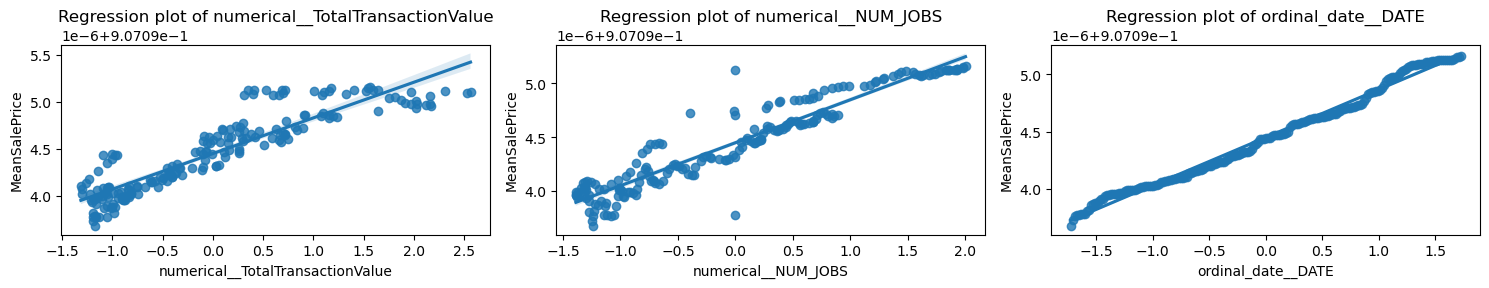

In [24]:
# Plot out the highly correlated features
eda.plot_regression_feature_correlations(corr_min=0.5)

## Perform unsupervised feature selection

Optimal number of features: 19


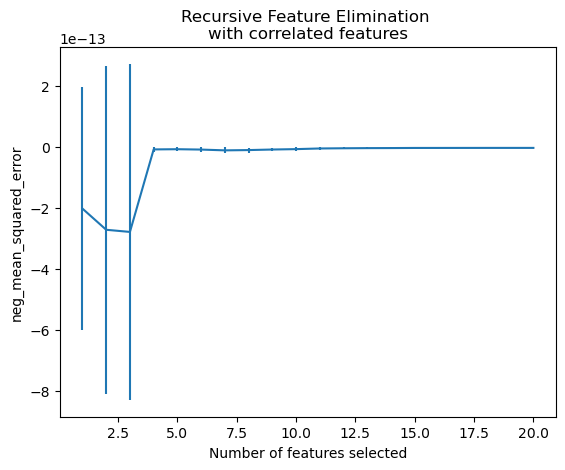

,mean_test_score,std_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,selected,ranking,feature_name
0,-2.012364e-13,3.984385e-13,-1.851828e-15,-2.333520e-15,-1.570697e-15,-2.312763e-15,-9.981131e-13,True,1,SalesCount
1,-2.705842e-13,5.371532e-13,-1.705890e-15,-2.545301e-15,-1.598412e-15,-2.181113e-15,-1.344890e-12,True,1,TotalTransactionValue
2,-2.776331e-13,5.508673e-13,-1.899975e-15,-2.766334e-15,-1.621461e-15,-2.510313e-15,-1.379367e-12,True,1,MarketTempIdx
3,-7.101433e-15,7.709654e-15,-6.828441e-15,-2.764229e-15,-1.330951e-15,-2.516028e-15,-2.206751e-14,True,1,DaysToClose
4,-6.416709e-15,7.194839e-15,-8.211813e-15,-2.440311e-15,-1.411355e-15,-2.910605e-16,-1.972901e-14,True,1,DaysOnZillow


In [25]:
# Try recursive feature elimination to find the optimal number of features for a linear regression model
regressor = LinearRegression()
rfecv_results_df = eda.perform_unsupervised_regression_rfe_feature_selection(regressor)
rfecv_results_df.head()

In [26]:
rfe_lr_selected_features = eda.get_rfe_selected_features(rfecv_results_df)
print(f"RFE LR Selected Features: {rfe_lr_selected_features}")

RFE LR Selected Features: ['SalesCount' 'TotalTransactionValue' 'MarketTempIdx' 'DaysToClose'
 'DaysOnZillow' 'ListingPriceCutAmt' 'ListingPriceCutPct' 'SaleToList'
 'NewConstructMeanSalePrice' 'NewConstructSalesCount'
 'PctListingsPriceCut' 'PctSoldAboveList' 'PctSoldBelowList'
 'MORTGAGE15US' 'MORTGAGE30US' 'RATE_DIFFERENCE' 'NUM_JOBS' 'GROWTH_PCT'
 'DATE']


Optimal number of features: 16


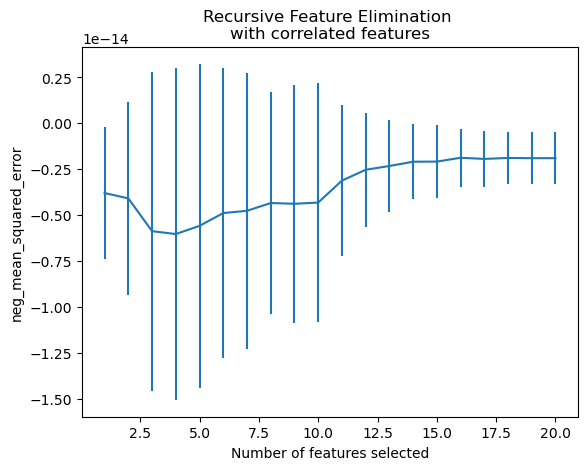

In [27]:
# Try recursive feature elimination to find the optimal number of features for a RidgeCV model
regressor = RidgeCV(alphas=np.logspace(-6, 6, num=7))
rfecv_results_df = eda.perform_unsupervised_regression_rfe_feature_selection(regressor)


In [28]:
rfe_ridge_selected_features = eda.get_rfe_selected_features(rfecv_results_df)
print(f"RFE Ridge Selected features: {rfe_ridge_selected_features}")

RFE Ridge Selected features: ['SalesCount' 'TotalTransactionValue' 'DaysToClose' 'DaysOnZillow'
 'ListingPriceCutAmt' 'ListingPriceCutPct' 'SaleToList'
 'NewConstructSalesCount' 'PctListingsPriceCut' 'PctSoldAboveList'
 'PctSoldBelowList' 'MORTGAGE15US' 'RATE_DIFFERENCE' 'NUM_JOBS'
 'GROWTH_PCT' 'DATE']


In [29]:
# Try using forward SFS (SequentialFeatureSelector) to select the top 10 features
sfs_ridge_selected_features = eda.perform_unsupervised_regression_sfs_feature_selection(n_features=6)
print(f"SFS Ridge Selected Features: {sfs_ridge_selected_features}")


RidgeCV best alpha 1.0
Selected 6 features by forward sequential featureselection in 0.751 seconds
SFS Ridge Selected Features: ['SalesCount', 'TotalTransactionValue', 'DaysOnZillow', 'MORTGAGE15US', 'NUM_JOBS', 'DATE']


In [30]:
# # Remove colinear features from the list of selected features
# # rfe_ridge_selected_features = [rfe_ridge_selected_features]
# rfe_ridge_selected_features = list(rfe_ridge_selected_features).remove('PctListingsPriceCut')
# rfe_ridge_selected_features

In [31]:
# Update EDA object with selected features from RFE
eda.selected_feature_list = rfe_ridge_selected_features

# Now get the list of selected ordinal columns
final_ordinal_cols = eda.get_final_ordinal_col_names(rfe_lr_selected_features)
len(final_ordinal_cols), final_ordinal_cols

(1, ['DATE'])

## Perform final EDA with selected features and ordinal columns

In [32]:
# Reset transformer properties to use the selected columns and ordinal columns
eda.ordinal_encoding_col_dict = {}
for col_name in final_ordinal_cols:
    eda.add_ordinal_encoding_column(col_name, None)

eda.feature_transformer = eda.create_feature_transformer()
eda.feature_transformer

ColumnTransformer(transformers=[('numerical',
                                 Pipeline(memory='named_steps',
                                          steps=[('pruner',
                                                  SimplePruner(infreq=0.95,
                                                               pct_miss=0.8)),
                                                 ('selector',
                                                  SelectedFeaturesTransformer(selected_feature_list=array(['SalesCount', 'TotalTransactionValue', 'DaysToClose',
       'DaysOnZillow', 'ListingPriceCutAmt', 'ListingPriceCutPct',
       'SaleToList', 'NewConstructSalesCount', 'Pc...
                                                                              '2011-07-31',
                                                                              '2011-06-30',
                                                                              '2011-09-30',
                                                                              '2011-08-31',
                                                                              '2010-12-31',
                                                                              '2010-11-30',
                                                                              '2010-02-28',
                                                                              '2012-11-30',
                                                                              '2012-05-31',
                                                                              '2012-10-31',
                                                                              '2009-12-31',
                                                                              '2010-10-31',
                                                                              '2010-03-31',
                                                                              '2010-01-31',
                                                                              '2013-03-31',
                                                                              '2013-02-28',
                                                                              '2010-09-30',
                                                                              '2012-12-31', ...]],
                                                                 encoded_missing_value=-2,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1)),
                                                 ('scaler', StandardScaler())]),
                                 ['DATE'])])

In [33]:
# Check feature analysis to ensure we have no multicollinearity (ie. no infinite vifs)
feature_analysis_df = eda.get_regression_feature_analysis_df()
feature_analysis_df.head()

Best RidgeCV alpha: 1.0 (R^2 score:  1.00)


,correlation_abs,coefficient_abs,pval,vif,PCA1_abs,PCA2_abs,total
ordinal_date__DATE,0.995056,3.255825e-07,0.797964,22.436500,0.118721,0.521827,1.635604
numerical__NUM_JOBS,0.947227,2.381799e-08,0.912055,19.525350,0.123377,0.532352,1.602957
numerical__TotalTransactionValue,0.904176,8.596487e-08,0.439681,28.148044,0.233755,0.432913,1.570845
numerical__SalesCount,0.487703,2.443689e-08,0.569259,6.142217,0.155360,0.265920,0.908982
numerical__PctSoldBelowList,0.142381,1.481854e-08,0.853132,155.375593,0.380354,0.134408,0.657143


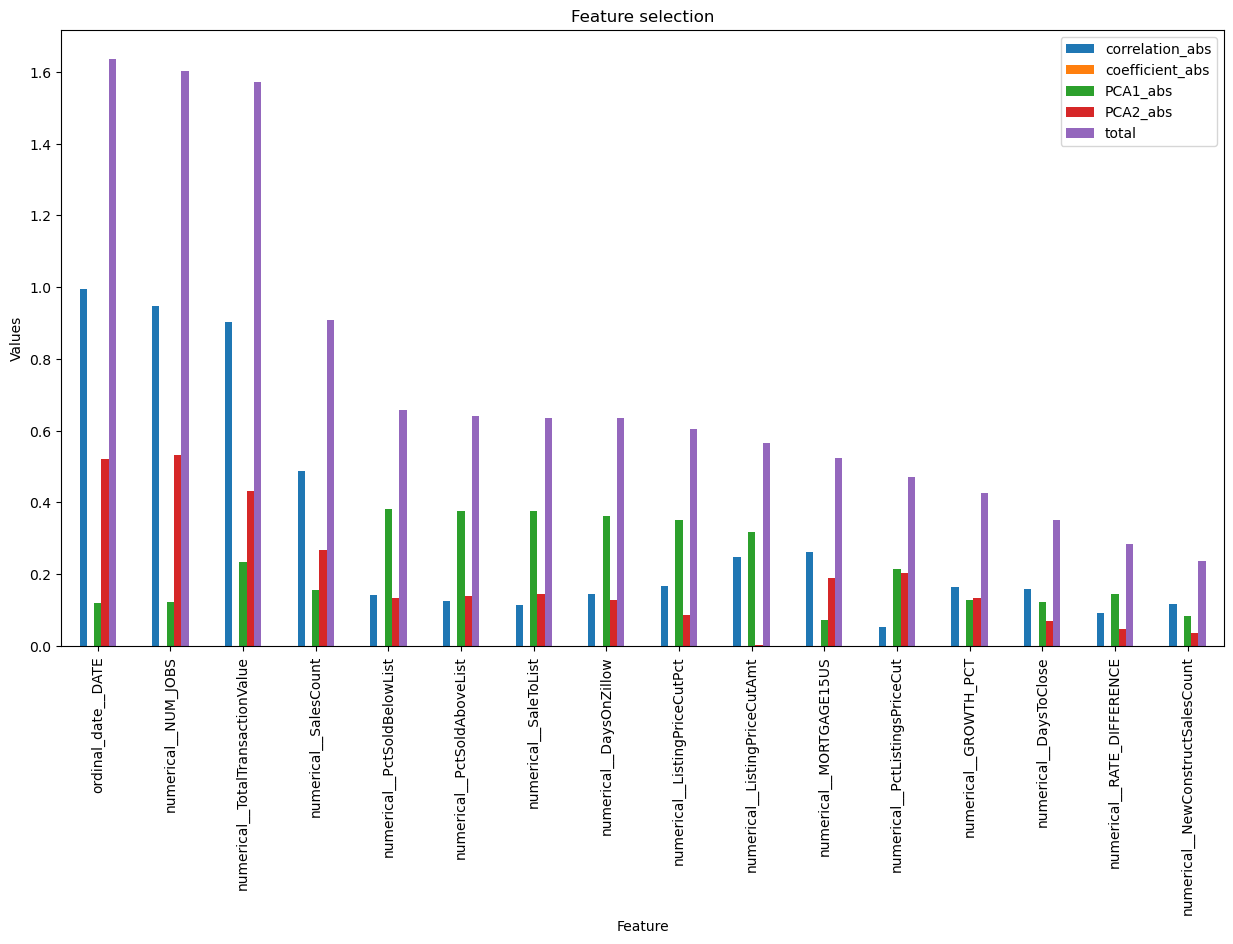

In [34]:
eda.plot_important_features(feature_analysis_df)

# Now do model analysis for multiple regression models

In [36]:
# Reload the data just to be safe
train_full_df = pd.read_csv(tampa_file_path)

# Create an instance of RegressorMultiModelEvaluator and set various properties
reg = RegressorMultiModelEvaluator(train_full_df, target_column=target_col)
reg.set_column_transformer_properties(selected_feature_list=eda.selected_feature_list, ordinal_feature_list=final_ordinal_cols)
reg.set_target_column_transformer(eda.target_transformer)

In [37]:
# Create a dict of models to test
model_dict: dict[str, RegressorMixin] = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0, random_state=42),
    'LassoCV': LassoCV(),
    'ElasticNetCV': ElasticNetCV(),
    'RidgeCV': RidgeCV(alphas=np.logspace(-6, 6, num=7)),
    'HistGradientBoost': HistGradientBoostingRegressor(max_iter=200, random_state=42)
}

In [38]:
# Evaluate the models
eval_df = reg.evaluate_models(model_dict)
eval_df

Number original X cols: 25
Number scaled X cols: 16


,train_r2,mse,r2,r2_adj,lr_cv_mean,lr_cv_std,time,y_pred
model_name,,,,,,,,
Ridge Regression,0.996433,6.631099e-16,0.995720,0.992607,0.532553,0.702359,0.007873,"[0.9070947478565498, 0.90709411162485, 0.90709..."
HistGradientBoost,0.999419,7.238557e-16,0.995328,0.991930,0.532553,0.702359,0.258006,"[0.9070946938876298, 0.9070941376017546, 0.907..."
ElasticNetCV,0.996679,7.502742e-16,0.995157,0.991635,0.532553,0.702359,0.044764,"[0.907094716972366, 0.9070941192172168, 0.9070..."
LassoCV,0.996679,7.502742e-16,0.995157,0.991635,0.532553,0.702359,0.043239,"[0.9070947169723639, 0.9070941192172175, 0.907..."
RidgeCV,0.996789,1.231880e-15,0.992049,0.986266,0.532553,0.702359,0.008245,"[0.9070947133534087, 0.9070941189259651, 0.907..."
Linear Regression,0.996789,1.270814e-15,0.991797,0.985832,0.532553,0.702359,0.008154,"[0.907094712725742, 0.9070941190014706, 0.9070..."


* Ridge CV has the highest r2 and adjusted r2 values and therefore the optimal choice

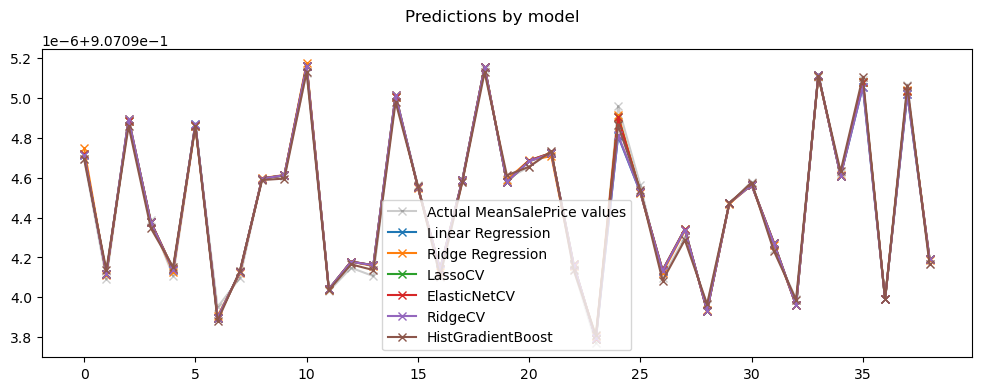

In [39]:
reg.plot_model_evaluations()

* Looks overfit to me

In [40]:
# Get the best model
reg.best_model_name

'Ridge Regression'

## Now use the best model to predict on the test data

In [41]:
# Load test data from a different city
combined_file_path = '../../Data/Clean/combined/all_cities_combined.csv'
test_full_df = pd.read_csv(combined_file_path)
test_full_df.head()

,DATE,MeanSalePrice,SalesCount,TotalTransactionValue,HomeValueIndex,HomeValueIndexSmSa,MarketTempIdx,DaysToClose,DaysOnZillow,ListingPriceCutAmt,...,PctSoldBelowList,MORTGAGE15US,MORTGAGE30US,RATE_DIFFERENCE,NUM_JOBS,GROWTH_PCT,People25PlusThousands_2019,PctHighSchoolDiploma_2019,PctBachelorsDegree_2019,CityName
0,2008-04-30,200954.0,6463.0,1.235943e+09,185168.707578,189442.061550,NaN,NaN,NaN,NaN,...,NaN,5.465,5.918,0.452,2454.9,-3.5,4414.04779,89.810682,41.859123,"ATLANTA, GA"
1,2008-05-31,203419.0,6729.0,1.317605e+09,185331.245765,188426.220342,NaN,NaN,NaN,NaN,...,NaN,5.600,6.036,0.436,2450.9,-6.2,4414.04779,89.810682,41.859123,"ATLANTA, GA"
2,2008-06-30,205746.0,7047.0,1.388670e+09,185185.095114,187437.288971,NaN,NaN,NaN,NaN,...,NaN,5.910,6.320,0.410,2442.4,-6.1,4414.04779,89.810682,41.859123,"ATLANTA, GA"
3,2008-07-31,205553.0,7086.0,1.429205e+09,184692.089305,186253.861325,NaN,NaN,NaN,NaN,...,NaN,5.972,6.426,0.454,2434.6,-6.8,4414.04779,89.810682,41.859123,"ATLANTA, GA"
4,2008-08-31,202855.0,6383.0,1.388101e+09,183376.364934,184882.815462,NaN,NaN,NaN,NaN,...,NaN,6.025,6.478,0.452,2429.3,-7.2,4414.04779,89.810682,41.859123,"ATLANTA, GA"


In [42]:
# Drop target column
combined_file_df = test_full_df[target_col]
test_full_df = test_full_df.drop(columns=[target_col]) 
test_full_df.head()

KeyError: "['MeanSalePrice'] not found in axis"

In [52]:
# Make predictions with HistGradientBoost
#reg.best_model = model_dict['Linear Regression']
lr_predictions = reg.predict(test_full_df)
lr_predictionsS

array([196606.75008567, 199628.83459339, 201684.87637794, 200652.66189617,
       198613.30124795, 191729.23822738, 186125.99765161, 178196.75506636,
       174843.94760544, 162387.25676913, 157376.17426905, 151286.45251209,
       154622.31205013, 161655.94872807, 175672.67480683, 181653.12194711,
       184316.01967694, 179911.72165015, 177349.01277639, 176507.67475473,
       173205.05438723, 170792.17534001, 166887.89797862, 165365.84205734,
       172394.7619298 , 179050.96870049, 182533.90984736, 183421.51819959,
       180779.08279687, 174021.4286768 , 160208.97338809, 155303.5431149 ,
       156680.42756807, 160929.87133251, 155989.5661641 , 153274.0432015 ,
       151944.39977619, 158076.85378968, 169213.1825001 , 169999.75961204,
       163865.77279975, 149984.0913178 , 149339.59270538, 148063.75151315,
       147432.32723577, 146805.18017669, 145563.55956816, 146182.27068307,
       148699.49313454, 150633.03055772, 158782.51424193, 167657.30942395,
       166124.09416407, 1

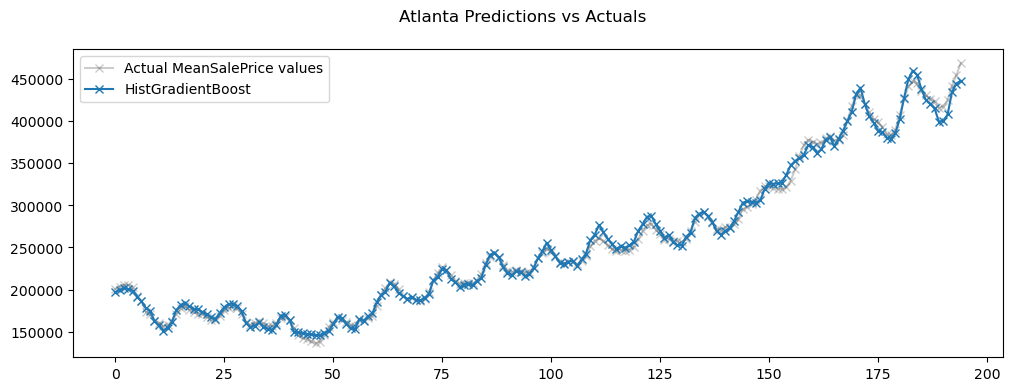

In [53]:
# Plot Actual vs Predictions
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Atlanta Predictions vs Actuals")
ax.plot(
    atlanta_actual_values,
    "x-",
    alpha=0.2,
    label=f"Actual {target_col} values",
    color="black",
)
ax.plot(lr_predictions, "x-", label="HistGradientBoost")
_ = ax.legend()